In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import metrics
warnings.filterwarnings('ignore')

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [2]:
movie_df = pd.read_csv(r'data/data_regression.csv')

In [3]:
movie_df.columns

Index(['imdb_id', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'movie_facebook_likes', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

# 1) Ranks + Facebook Likes

In [4]:
classification_df = movie_df.drop(columns=['imdb_id', 'director_name', 'num_critic_for_reviews',
       'actor_2_name',
       'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users',
       'actor_3_name', 'plot_keywords',
       'num_user_for_reviews',
       'title_year', 'imdb_score',
       'movie_facebook_likes'])

In [5]:
classification_df

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,language,country,content_rating,budget,...,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank,gross_budget_ratio
0,123.0,446.0,821.0,20000.0,22209,1.0,English,USA,PG-13,48000000.0,...,1,0,0,0,0,8,6,3,4,0.981155
1,88.0,104.0,318.0,628.0,2726,0.0,English,USA,PG,3500000.0,...,0,0,0,0,0,8,2,3,4,23.828571
2,104.0,116.0,83.0,1000.0,1662,0.0,English,USA,R,4500000.0,...,0,0,1,0,0,7,3,3,3,13.078468
3,148.0,644.0,326.0,1000.0,2566,1.0,English,USA,R,27000000.0,...,0,0,1,0,1,8,3,3,4,2.007407
4,98.0,11000.0,484.0,13000.0,14921,3.0,English,USA,R,6000000.0,...,0,0,0,0,1,7,7,3,5,6.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,92.0,89.0,190.0,17000.0,17860,0.0,English,USA,R,35000000.0,...,0,0,0,0,0,7,5,3,4,1.579766
3848,100.0,24.0,851.0,15000.0,18786,9.0,English,USA,R,20000000.0,...,0,0,0,0,0,7,5,5,5,2.773065
3849,92.0,89.0,355.0,729.0,2848,4.0,English,USA,R,5000000.0,...,0,0,0,0,0,5,2,4,4,2.335036
3850,81.0,26.0,300.0,2000.0,3344,0.0,English,USA,PG-13,4900000.0,...,0,0,0,0,0,7,3,3,4,11.537962


## 1.1) All Movies

In [6]:
classification1_df=classification_df.drop(columns=['country','language'])
df1 = pd.get_dummies(classification1_df, columns=['content_rating'])
df1 = df1.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df1['gross_budget_ratio'].quantile(0.25)
Q3 = df1['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df1['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df1['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df1=df1.loc[filtering] 
df1

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,budget,actor_2_facebook_likes,Biography,Comedy,...,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank,gross_budget_ratio,content_rating_PG,content_rating_PG-13,content_rating_R
0,123.0,446.0,821.0,20000.0,22209,1.0,4.800000e+07,1000.0,0,1,...,0,0,8,6,3,4,0.981155,0,1,0
3,148.0,644.0,326.0,1000.0,2566,1.0,2.700000e+07,809.0,0,1,...,0,1,8,3,3,4,2.007407,0,0,1
5,124.0,42.0,161.0,801.0,1462,0.0,2.000000e+07,174.0,1,1,...,0,1,5,3,2,3,0.100000,1,0,0
6,124.0,150.0,572.0,874.0,2667,0.0,5.166449e+07,816.0,1,0,...,0,1,7,3,4,4,1.546517,1,0,0
11,325.0,517.0,678.0,12000.0,14255,0.0,4.400000e+07,849.0,0,0,...,0,1,7,6,3,5,0.034091,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846,121.0,35.0,473.0,4000.0,6617,0.0,5.000000e+06,849.0,0,0,...,0,0,7,4,3,4,0.940072,0,1,0
3847,92.0,89.0,190.0,17000.0,17860,0.0,3.500000e+07,329.0,0,1,...,0,0,7,5,3,4,1.579766,0,0,1
3848,100.0,24.0,851.0,15000.0,18786,9.0,2.000000e+07,1000.0,0,1,...,0,0,7,5,5,5,2.773065,0,0,1
3849,92.0,89.0,355.0,729.0,2848,4.0,5.000000e+06,706.0,0,1,...,0,0,5,2,4,4,2.335036,0,0,1


## 1.1.1) Without log and feature elimination

In [7]:
X = df1.drop(columns=['gross_budget_ratio'])
y = df1['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2459, 26)
Dimensionality of X_test : (1054, 26)
Dimensionality of y_train: (2459,)
Dimensionality of y_test : (1054,)


### 1.1.1.1) Ridge Regression

In [8]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [9]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 18.0}
ridge score: -1.0024779279418032
ridge MSE: 1.0024779279418032
ridge best estimator coef: [ 0.08951015  0.2273603   0.16811345  0.02748369  0.09949078  0.11097912
 -0.15084317  0.05616562 -0.0953783   0.04050487 -0.11304148 -0.16548098
 -0.04510271 -0.01279968 -0.15607827  0.16507818 -0.16034106 -0.26173361
 -0.0824385   0.36660773  0.13810507  0.16492328  0.27656015  0.23751482
  0.26380684  0.11639505]


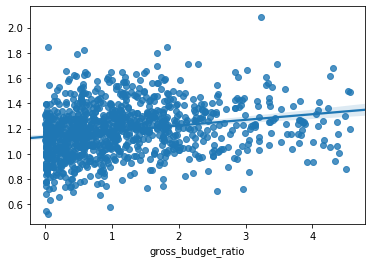

In [10]:
sns.regplot(y_test, y_pred )

### 1.1.1.2) Lasso Regression

In [11]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
Lasso = linear_model.Lasso()
clf2 = GridSearchCV(Lasso, parameters, scoring ='neg_mean_squared_error')
clf2.fit(X_train_scaled, y_train)

y_pred = clf2.predict(X_test_scaled)

print("Lasso best parameters:", clf2.best_params_)
print("Lasso score:", clf2.score(X_test_scaled, y_test))
print("Lasso MSE:", mean_squared_error(y_test, clf2.predict(X_test_scaled)))
print("Lasso best estimator coef:", clf2.best_estimator_.coef_)

Lasso best parameters: {'alpha': 0.1}
Lasso score: -1.0544373009111565
Lasso MSE: 1.0544373009111565
Lasso best estimator coef: [-0.  0.  0.  0.  0.  0. -0.  0. -0.  0. -0. -0.  0. -0. -0.  0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0. -0.]


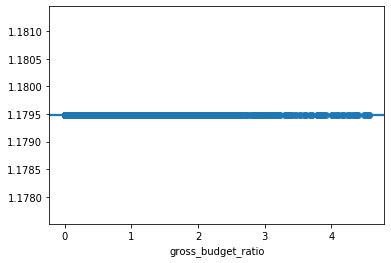

In [12]:
sns.regplot(y_test, y_pred )

### 1.1.1.3) Decision Tree Regressor

In [13]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.25, 'min_samples_split': 0.001}
DTR score: -1.0380659897215243
DTR MSE: 1.0380659897215243


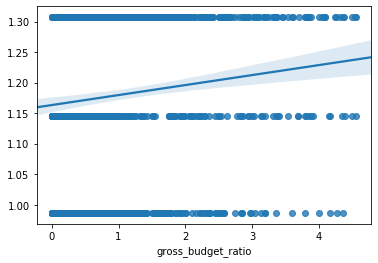

In [14]:
sns.regplot(y_test, y_pred )

### 1.1.1.4) Random Forest Regressor

In [15]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -1.0006784214296367
RFR MSE: 1.0006784214296367


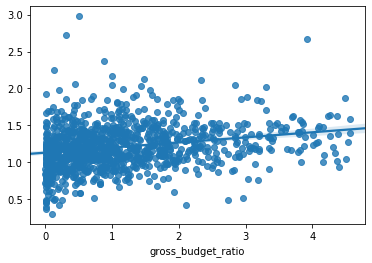

In [16]:
sns.regplot(y_test, y_pred )

## 1.1.2) With taking log and feature elimination

### log

In [17]:
df2 = df1.copy()
df2['budget'] = np.log(df2['budget'])
df2['director_facebook_likes'] = df2['director_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_1_facebook_likes'] = df2['actor_1_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_2_facebook_likes'] = df2['actor_2_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['actor_3_facebook_likes'] = df2['actor_3_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df2['cast_total_facebook_likes'] = df2['cast_total_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))

### elimination

In [18]:
df2.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R'],
      dtype='object')

In [19]:
df2 = df2.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

In [20]:
X = df2.drop(columns=['gross_budget_ratio'])
y = df2['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2459, 20)
Dimensionality of X_test : (1054, 20)
Dimensionality of y_train: (2459,)
Dimensionality of y_test : (1054,)


### 1.1.2.1) Ridge Regression

In [21]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [22]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 0.2}
ridge score: -0.981220268632142
ridge MSE: 0.981220268632142
ridge best estimator coef: [ 0.76937558  0.22445522  0.68540647 -1.68173593  3.07432209 -2.03019251
 -0.32914727  0.08178358 -0.22052498 -0.01079714  0.32470322 -0.10362878
 -0.05345683  0.70121328 -0.02194457 -0.12059555 -0.16579817  0.32509969
  0.44316637  0.21984443]


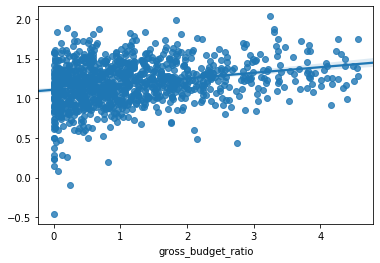

In [23]:
sns.regplot(y_test, y_pred )

### 1.1.2.2) Lasso Regression

In [24]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
Lasso = linear_model.Lasso()
clf2 = GridSearchCV(Lasso, parameters, scoring ='neg_mean_squared_error')
clf2.fit(X_train_scaled, y_train)

y_pred = clf2.predict(X_test_scaled)

print("Lasso best parameters:", clf2.best_params_)
print("Lasso score:", clf2.score(X_test_scaled, y_test))
print("Lasso MSE:", mean_squared_error(y_test, clf2.predict(X_test_scaled)))
print("Lasso best estimator coef:", clf2.best_estimator_.coef_)

Lasso best parameters: {'alpha': 0.1}
Lasso score: -1.0544373009111565
Lasso MSE: 1.0544373009111565
Lasso best estimator coef: [-0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.
  0. -0.]


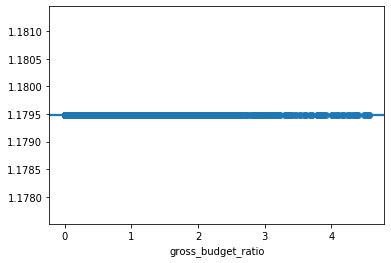

In [25]:
sns.regplot(y_test, y_pred )

### 1.1.2.3) Decision Tree Regressor

In [26]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.25, 'min_samples_split': 0.001}
DTR score: -1.0380659897215243
DTR MSE: 1.0380659897215243


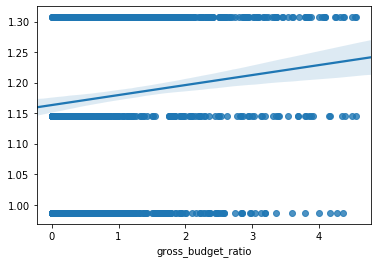

In [27]:
sns.regplot(y_test, y_pred )

### 1.1.2.4) Random Forest Regressor

In [28]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -0.9999452898610167
RFR MSE: 0.9999452898610167


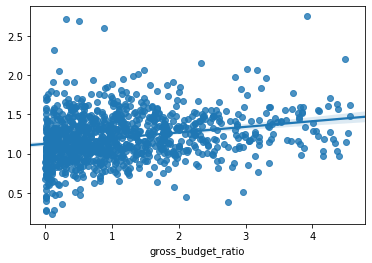

In [29]:
sns.regplot(y_test, y_pred )

## 1.2) Only US and UK Movies

In [30]:
classification2_df= classification_df.copy()
classification2_df = classification2_df[(classification2_df.country=='USA') | (classification2_df.country=='UK')]
classification2_df = classification2_df[(classification2_df.language=='English')]
classification2_df=classification2_df.drop(columns=['country','language'])
df3 = pd.get_dummies(classification2_df, columns=['content_rating'])
df3 = df3.drop(columns =['content_rating_Not Rated','content_rating_G','content_rating_X','content_rating_NC-17'])
Q1 = df3['gross_budget_ratio'].quantile(0.25)
Q3 = df3['gross_budget_ratio'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filtering = (df3['gross_budget_ratio'] >= Q1 - 1.5 * IQR) & (df3['gross_budget_ratio'] <= Q3 + 1.5 *IQR)
df3=df3.loc[filtering]
df3

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,budget,actor_2_facebook_likes,Biography,Comedy,...,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank,gross_budget_ratio,content_rating_PG,content_rating_PG-13,content_rating_R
0,123.0,446.0,821.0,20000.0,22209,1.0,4.800000e+07,1000.0,0,1,...,0,0,8,6,3,4,0.981155,0,1,0
3,148.0,644.0,326.0,1000.0,2566,1.0,2.700000e+07,809.0,0,1,...,0,1,8,3,3,4,2.007407,0,0,1
5,124.0,42.0,161.0,801.0,1462,0.0,2.000000e+07,174.0,1,1,...,0,1,5,3,2,3,0.100000,1,0,0
6,124.0,150.0,572.0,874.0,2667,0.0,5.166449e+07,816.0,1,0,...,0,1,7,3,4,4,1.546517,1,0,0
11,325.0,517.0,678.0,12000.0,14255,0.0,4.400000e+07,849.0,0,0,...,0,1,7,6,3,5,0.034091,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846,121.0,35.0,473.0,4000.0,6617,0.0,5.000000e+06,849.0,0,0,...,0,0,7,4,3,4,0.940072,0,1,0
3847,92.0,89.0,190.0,17000.0,17860,0.0,3.500000e+07,329.0,0,1,...,0,0,7,5,3,4,1.579766,0,0,1
3848,100.0,24.0,851.0,15000.0,18786,9.0,2.000000e+07,1000.0,0,1,...,0,0,7,5,5,5,2.773065,0,0,1
3849,92.0,89.0,355.0,729.0,2848,4.0,5.000000e+06,706.0,0,1,...,0,0,5,2,4,4,2.335036,0,0,1


## 1.2.1) Without log and feature elimination

In [31]:
X = df3.drop(columns=['gross_budget_ratio'])
y = df3['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2122, 26)
Dimensionality of X_test : (910, 26)
Dimensionality of y_train: (2122,)
Dimensionality of y_test : (910,)


### 1.2.1.1) Ridge Regression

In [32]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [33]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 3.0}
ridge score: -1.0943702687570538
ridge MSE: 1.0943702687570538
ridge best estimator coef: [ 1.25039997 -0.00237299  0.3716806  -0.17359832  0.14259413  0.07430163
 -1.10314361  0.03385511 -0.11617377  0.12951599 -0.06160324 -0.20988328
 -0.03935857  0.02765709 -0.07286937  0.36194573 -0.04997536 -0.05234101
 -0.11089592  0.82430721  0.15069742  0.2046042   0.18547184  0.13966627
  0.25123073  0.04791238]


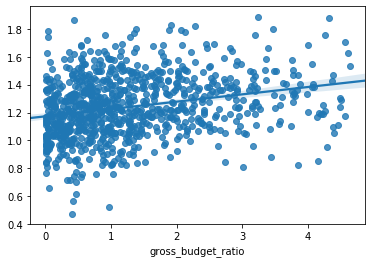

In [34]:
sns.regplot(y_test, y_pred )

### 1.2.1.2) Lasso Regression

In [35]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
Lasso = linear_model.Lasso()
clf2 = GridSearchCV(Lasso, parameters, scoring ='neg_mean_squared_error')
clf2.fit(X_train_scaled, y_train)

y_pred = clf2.predict(X_test_scaled)

print("Lasso best parameters:", clf2.best_params_)
print("Lasso score:", clf2.score(X_test_scaled, y_test))
print("Lasso MSE:", mean_squared_error(y_test, clf2.predict(X_test_scaled)))
print("Lasso best estimator coef:", clf2.best_estimator_.coef_)

Lasso best parameters: {'alpha': 0.1}
Lasso score: -1.1678930038823336
Lasso MSE: 1.1678930038823336
Lasso best estimator coef: [ 0.  0.  0.  0.  0.  0. -0.  0. -0.  0. -0. -0.  0. -0. -0.  0. -0. -0.
 -0.  0.  0.  0.  0.  0.  0. -0.]


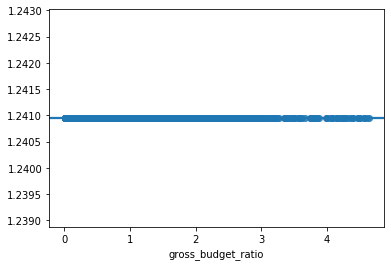

In [36]:
sns.regplot(y_test, y_pred )

### 1.2.1.3) Decision Tree Regressor

In [37]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.5}
DTR score: -1.1558325328918793
DTR MSE: 1.1558325328918793


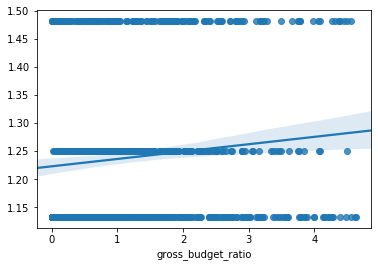

In [38]:
sns.regplot(y_test, y_pred )

### 1.2.1.4) Random Forest Regressor

In [39]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -1.0739512841361258
RFR MSE: 1.0739512841361258


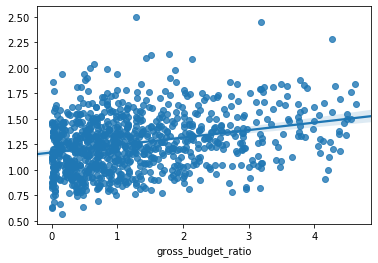

In [40]:
sns.regplot(y_test, y_pred )

## 1.2.2) With taking log and feature elimination

### log

In [41]:
df4 = df3.copy()
df4['budget'] = np.log(df4['budget'])
df4['director_facebook_likes'] = df4['director_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df4['actor_1_facebook_likes'] = df4['actor_1_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df4['actor_2_facebook_likes'] = df4['actor_2_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df4['actor_3_facebook_likes'] = df4['actor_3_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))
df4['cast_total_facebook_likes'] = df4['cast_total_facebook_likes'].transform(lambda x: 0 if x <= 3 else np.log(x))

### elimination

In [42]:
df4.columns

Index(['duration', 'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'Biography',
       'Comedy', 'Crime', 'Drama', 'Romance', 'Mystery_Thriller_Horror',
       'Sci-Fi_Fantasy', 'Family_Animation', 'Action_Adventure', 'History_War',
       'Others', 'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R'],
      dtype='object')

In [43]:
df4 = df4.drop(columns = ['facenumber_in_poster', 'Biography', 'Crime',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'History_War'])

In [44]:
X = df4.drop(columns=['gross_budget_ratio'])
y = df4['gross_budget_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

Dimensionality of X_train: (2122, 20)
Dimensionality of X_test : (910, 20)
Dimensionality of y_train: (2122,)
Dimensionality of y_test : (910,)


### 1.2.2.1) Ridge Regression

In [45]:
MMScaler = MinMaxScaler()
X_train_scaled = MMScaler.fit_transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [46]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
ridge = Ridge()
clf1 = GridSearchCV(ridge, parameters, scoring ='neg_mean_squared_error')
clf1.fit(X_train_scaled, y_train)

y_pred = clf1.predict(X_test_scaled)

print("ridge best parameters:", clf1.best_params_)
print("ridge score:", clf1.score(X_test_scaled, y_test))
print("ridge MSE:", mean_squared_error(y_test, clf1.predict(X_test_scaled)))
print("ridge best estimator coef:", clf1.best_estimator_.coef_)

ridge best parameters: {'alpha': 0.1}
ridge score: -1.1192741966328723
ridge MSE: 1.1192741966328723
ridge best estimator coef: [ 1.44188176  0.13434856  0.27852821 -2.59223718  3.53347912 -1.37081727
 -0.10647289  0.14998151 -0.19385574 -0.00719526  0.35061184 -0.08815629
 -0.09400236  0.76387135  0.20154337 -0.12117456 -0.13793526  0.19484628
  0.30003753  0.12665032]


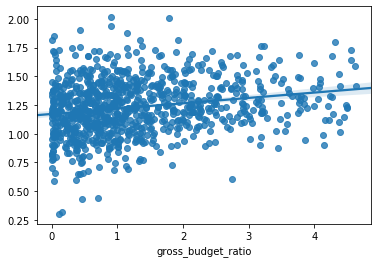

In [47]:
sns.regplot(y_test, y_pred )

### 1.2.2.2) Lasso Regression

In [48]:
parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1)))}
Lasso = linear_model.Lasso()
clf2 = GridSearchCV(Lasso, parameters, scoring ='neg_mean_squared_error')
clf2.fit(X_train_scaled, y_train)

y_pred = clf2.predict(X_test_scaled)

print("Lasso best parameters:", clf2.best_params_)
print("Lasso score:", clf2.score(X_test_scaled, y_test))
print("Lasso MSE:", mean_squared_error(y_test, clf2.predict(X_test_scaled)))
print("Lasso best estimator coef:", clf2.best_estimator_.coef_)

Lasso best parameters: {'alpha': 0.1}
Lasso score: -1.1678930038823336
Lasso MSE: 1.1678930038823336
Lasso best estimator coef: [ 0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.
  0. -0.]


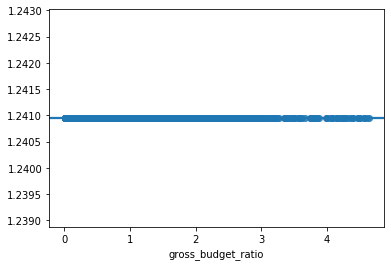

In [49]:
sns.regplot(y_test, y_pred )

### 1.2.2.3) Decision Tree Regressor

In [50]:
DTSplitList=[0.001,0.01,0.05,0.1,0.5,0.99]
DTLeafList=[0.0005,0.005,0.025,0.05,0.1,0.25,0.5]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-3)),'min_samples_leaf': DTLeafList, 'min_samples_split':DTSplitList}
DTR = DecisionTreeRegressor(random_state=10)
clf3 = GridSearchCV(DTR, parameters, scoring ='neg_mean_squared_error')
clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_test)

print("DTR best parameters:", clf3.best_params_)
print("DTR score:", clf3.score(X_test, y_test))
print("DTR MSE:", mean_squared_error(y_test, clf3.predict(X_test)))

DTR best parameters: {'criterion': 'mse', 'max_depth': 100, 'min_samples_leaf': 0.0005, 'min_samples_split': 0.5}
DTR score: -1.1558325328918793
DTR MSE: 1.1558325328918793


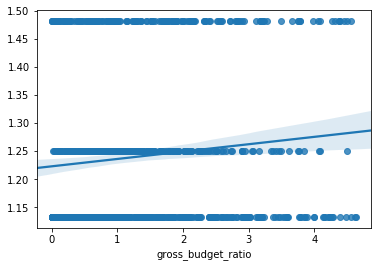

In [51]:
sns.regplot(y_test, y_pred )

### 1.2.2.4) Random Forest Regressor

In [52]:
RFEstimatorList = [25,50,100,200]
criterion =['mse']
parameters = {'criterion':criterion,'max_depth':list(range(100,0,-10)),'n_estimators':RFEstimatorList}

RFR = RandomForestRegressor(random_state=10)
clf4 = GridSearchCV(RFR, parameters, cv=5, verbose=0,scoring ='neg_mean_squared_error')
clf4.fit(X_train, y_train)

y_pred = clf4.predict(X_test)

print("RFR best parameters:", clf4.best_params_)
print("RFR score:", clf4.score(X_test, y_test))
print("RFR MSE:", mean_squared_error(y_test, clf4.predict(X_test)))

RFR best parameters: {'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}
RFR score: -1.0749387777978956
RFR MSE: 1.0749387777978956


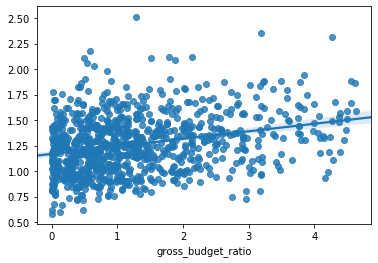

In [53]:
sns.regplot(y_test, y_pred )